# QOSF Mentorship: Task 4

This notebook is organized into 4 parts:

1. Concepts and implementation of the VQE Circuit
2. Notes and thoughts on Python implementation
3. Experimenting with classical optimizers and noise models
4. Where do we go from here?

To review, the objective of Task 4 was to create a VQE-like circuit from scratch and use this circuit to find the lowest eigenvalue state of the following matrix:

$$\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 0 & -1 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}$$




## Concepts and implementation of the VQE Circuit

In order to create this VQE (Variational Quantum Eigensolver) circuit from scratch, we will need to implement the following parts:

    1. Determine an initial value for theta
    2. Construct circuit and run simulator for theta 
    3. Use simulator results to calculate expectation values 
    4. Use expectation values to calculate energy state for theta
    5. Choose another value for theta and repeat steps 1 - 4 until full range of theta has been calculated.
    6. Lowest value for theta will be ground state

![overview](images/overview.PNG)

As we tweak the value of our parameter $\theta$, we get a different ground state value from our VQE algorithm. Our objective is to find the lowest eigenvalue by manipulating the value of theta. (Observant readers will recognize an opportunity to optimize this process, but that is a topic for another time!) Thanks to the Variational principle we know that any theta we provide to our VQE algorithm will never produce an energy state lower than the lowest eigenvalue but rather slowly approach it. This fact underpins the effectiveness of this algorithm. Of course, like any quantum algorithm/circuit these facts ring true under ideal, not noisy, circumstances. However, we know that is not the reality of NISQ-era quantum computers. Later in this notebook we'll explore the way that noise effects VQE's ability to locate the ground state.


(sidenote: for a more detailed look into the mechanics of VQE check out one of the wonderful sources below)

https://www.mustythoughts.com/variational-quantum-eigensolver-explained

https://github.com/DavitKhach/quantum-algorithms-tutorials/blob/master/variational_quantum_eigensolver.ipynb

#### Step 1: Decompose our Hamiltonian

We can't simply throw a hamiltonian of any size into our VQE circuit and calculate the lowest eigenvalue state. That would be like trying to eat an entire XL pizza in one bite. Utterly impossible. Instead, we want to break up the Hamiltonian into a sum of Pauli matrices, or in this 2-qubit case, the sum of tensored product of Pauli matrices.

For this task we are allowed to decompose our Hamiltonian into four distinct states (II, XX, YY, and ZZ). We can imagine our generalized Hamiltonian decomposed into its constituent tensored Pauli matrices like so:

$$H = a (I \otimes I)  +  b (\sigma_x \otimes \sigma_x)  +  c (\sigma_y \otimes \sigma_y)  +  d (\sigma_z \otimes \sigma_z) $$

The a, b, c, d values are coefficients for each decomposed matrix and work as a "weight" when multiplied with the expectation value. 

In order to decompose our hamiltonian we need to calculate the trace of each tensored pauli matrix above. We can do that by applying the trace formula to each pauli matrix in the hamiltonian:

$$ h_{ij} = \dfrac{1}{4} (\sigma_i \otimes \sigma_j * H)$$

For example, the trace for $\sigma_z \otimes \sigma_z$ is 0.5 as shown below:

$$ h_{zz} = \dfrac{1}{4} tr(\sigma_z \otimes \sigma_z * H)$$

$$ h_{zz} = \dfrac{1}{4} tr(\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & -1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} * \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 0 & -1 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix})$$

$$ h_{zz} = \dfrac{1}{4} tr(\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix})$$

$$ h_{zz} = \dfrac{1}{4} * 2$$

$$ h_{zz} = 0.5$$


We repeat this process for $(\sigma_x \otimes \sigma_x)$, $(\sigma_y \otimes \sigma_y)$, and $(I \otimes I)$: 

$$ h_{zz} = 0.5 \qquad h_{ii} = 0.5 \qquad h_{yy} = -0.5 \qquad h_{xx} = -0.5$$


Putting all these pieces together, we have now decomposed our hamiltonian into Pauli matrices which means that we are ready to calculate our ground state using our VQE circuit.

    
$$H = 0.5 (I \otimes I)  -  0.5 (\sigma_x \otimes \sigma_x)  -  0.5 (\sigma_y \otimes \sigma_y)  +  0.5 (\sigma_z \otimes \sigma_z) $$


You can decompose hamiltonians with ease using the snippet below:

In [3]:
from vqe import VQE
import numpy as np
import matplotlib.pyplot as plt
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.providers.aer import noise
from qiskit.providers.aer.noise import NoiseModel, pauli_error, depolarizing_error
from skquant.opt import minimize
from optimizers import ClassicalOptimizer
import json

In [21]:
ham = np.array([[1, 0, 0, 0], [0, 0, -1, 0], [0, -1, 0, 0], [0, 0, 0, 1]])
vqe = VQE(shots=1000, angle_range=np.linspace(0, 2 * np.pi, 20))
print("Decomposed Hamiltonian: ", vqe.decompose_hamiltonian(hamiltonian=ham))

Decomposed Hamiltonian:  {'II': '(0.5+0j)', 'XX': '(-0.5+0j)', 'YY': '(-0.5+0j)', 'ZZ': '(0.5+0j)'}


#### Step 2: Compose VQE Circuit

Before we proceed to the next part, let's briefly review the components of our quantum circuit. 


##### The Ansatz

Our ansatz consists of three gates the Hadamard gate (acting on the 1st qubit), the 2-qubit CNOT gate, and the parametrized $RX(\theta)$ gate (acting on the first qubit). The ansatz allows us to trasform our initial $\left| 00 \right\rangle$ state into the arbitrary state $\left| \psi \right\rangle$. Additionally the ansatz represents the space on the Bloch Sphere that is searchable for the ground state.    
    
    
##### The Pre-measurement rotations 

A crucial step before we measure our qubits is to apply pre-measurement rotations. Why do we need to do this? We conduct all measurements in the Z axis in order to get results in the computational basis vectors 0 and 1. So this brings up the question of what to do if we have psi states along the X and Y axes. When we measure in the X axis we perform a $RY(-\pi/2)$ rotation, and we perform a $RX(\pi/2)$ rotation when measuring in the Y axis. No rotations need to be applied when measuring in the Z axis. Because of these differences our quantum circuit can look different considering which axis we are measuring in.


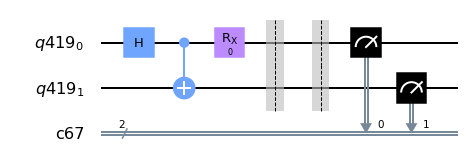

In [18]:
vqe = VQE(shots=1000, angle_range=np.linspace(0, 2 * np.pi, 20))
circuit = vqe.generate_circuit("Z")
circuit.draw("mpl")

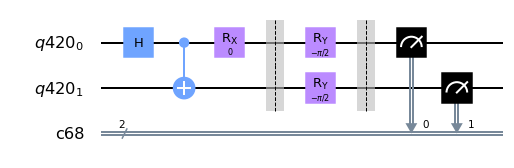

In [19]:
vqe = VQE(shots=1000, angle_range=np.linspace(0, 2 * np.pi, 20))
circuit = vqe.generate_circuit("X")
circuit.draw("mpl")

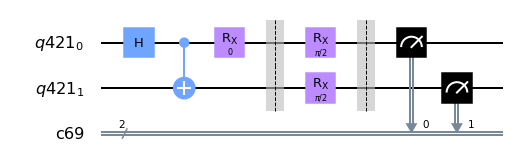

In [20]:
vqe = VQE(shots=1000, angle_range=np.linspace(0, 2 * np.pi, 20))
circuit = vqe.generate_circuit("Y")
circuit.draw("mpl")

##### Measurement 
    
Finally, we are ready to measure! Since this is a two qubit gate, we store the outcome of qubit 1 on a classical bit 1 and the outcome of qubit 2 onto classical bit 2. Therefore our results can be at most spread across 4 possible, 2-qubit states:  00, 01, 10, 11. 

Due to our pre-measurement rotations we can calculate all our measurements on the state $\sigma_z \otimes \sigma_z$. Recall that quantum  measurements take the form: $$\left\langle \psi \right| \sigma_z \otimes \sigma_z \left| \psi \right\rangle$$

We can interpret measurement by calculating the arbitrary state $\left| \psi \right\rangle$ with our four possible state to determine whether we end up with a an eigenvalue of 1 or -1

$$\left\langle 00 \right| \sigma_z \otimes \sigma_z \left| 00 \right\rangle \qquad \left\langle 01 \right| \sigma_z \otimes \sigma_z \left| 01 \right\rangle \qquad \left\langle 10 \right| \sigma_z \otimes \sigma_z \left| 10 \right\rangle \qquad \left\langle 11 \right| \sigma_z \otimes \sigma_z \left| 11 \right\rangle \qquad$$

Let's quickly do the calculations here:

$$ \left\langle 00 \right| \sigma_z \otimes \sigma_z \left| 00 \right\rangle = \left\langle 00 \right| \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & -1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} \left| 00 \right\rangle \qquad \left\langle 01 \right| \sigma_z \otimes \sigma_z \left| 01 \right\rangle = \left\langle 01 \right| \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & -1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} \left| 01 \right\rangle$$

$$\left\langle 10 \right| \sigma_z \otimes \sigma_z \left| 10 \right\rangle = \left\langle 10 \right| \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & -1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} \left| 10 \right\rangle \qquad \left\langle 11 \right| \sigma_z \otimes \sigma_z \left| 11 \right\rangle = \left\langle 11 \right| \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & -1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} \left| 11 \right\rangle$$

When each of these matrices are multiplied, we end up with the following eigenvalues:

$$ \left\langle 00 \right| \sigma_z \otimes \sigma_z \left| 00 \right\rangle = 1 \qquad \left\langle 01 \right| \sigma_z \otimes \sigma_z \left| 01 \right\rangle = -1 \qquad \left\langle 10 \right| \sigma_z \otimes \sigma_z \left| 10 \right\rangle = -1 \qquad \left\langle 11 \right| \sigma_z \otimes \sigma_z \left| 11 \right\rangle = 1 $$

### Step 3: Calculate and sum the expectation value for each angle theta

At this point our quantum simulator has run a 1000 simulations and has provided us with the results in this dictionary format with each possible state as the key and the number of times that state was manifested as the value:

```
    {"00": 491,"01": 13,"10": 11,"11": 485}
```

The calculation of the expectation value is average of the sum of results. Let $C$ be the total shots, where $C_{ij}$ is the total number of measurements for state $ij$. 

$$expectation = \dfrac{C_{00} - C_{01} - C_{10} + C_{11}}{C_{total}}$$

You may be wondering why do $C_{01}$ and $C_{10}$ have negative coefficients? If you refer to the previous section, the eigenvalues for states $\left| 01 \right\rangle$ and $\left| 10 \right\rangle$ are both -1 which become the coefficients in our expectation calculation. 

This process is repeated for each decomposed hamiltonian in our original equation:

$$H = 0.5 (I \otimes I)  -  0.5 (\sigma_x \otimes \sigma_x)  -  0.5 (\sigma_y \otimes \sigma_y)  +  0.5 (\sigma_z \otimes \sigma_z) $$

For example, if $\theta = 0$ our expectation values for each decomposed hamiltonian will be as follows:

$$H = 0.5 (1)  -  0.5 (1)  -  0.5 (-1)  +  0.5 (1) $$
$$H = 0.5 + 0.5 $$
$$H = 1$$

You can check that this true by reviewing the calculated expectation values for Z, X, and Y below. Additionally, it's important to note that the expectation value for $(I \otimes I)$ is always 1.

In [7]:
vqe = VQE(angle_range=np.linspace(0, 2 * np.pi, 20))
circuit = vqe.generate_circuit("Z")
results = vqe.execute_measurement(circuit)
print("Expectation value for ZZ: ", vqe.calculate_expectation_values(results, "Z"))

Expectation value for ZZ:  1.0


In [8]:
vqe = VQE(angle_range=np.linspace(0, 2 * np.pi, 20))
circuit = vqe.generate_circuit("X")
results = vqe.execute_measurement(circuit)
print("Expectation value for XX: ", vqe.calculate_expectation_values(results, "X"))

Expectation value for XX:  1.0


In [9]:
vqe = VQE(angle_range=np.linspace(0, 2 * np.pi, 20))
circuit = vqe.generate_circuit("Y")
results = vqe.execute_measurement(circuit)
print("Expectation value for YY: ", vqe.calculate_expectation_values(results, "Y"))

Expectation value for YY:  -1.0


#### Step 4: Return lowest eigenvalue

For a given theta, executing step 1 through step 3 of our process provides us with a value for each part of this decomposed Hamiltonian. These values are summed, giving us the energy state for the given theta. At this point, the VQE algorithm will provide another value for theta and repeat this process generating a unique ground state value for this new theta until we have calculated an energy state for every theta in our angle range. Since there is no classical optimizer we simply step through each theta value in the provided angle range (for this task we will use $0$ to $2\pi$).

Now we have a list of possible ground states correlated to each value of $\theta$. In order to find the lowest eigenvalue (the ground state) we simply choose the lowest value in the list.

![ground](images/ground_state.PNG)

#### Putting the pieces together

Now that we have thoroughly outlined the process, we now execute the VQE algorithm to find the lowest eigenvalue for our task, specifically the matrix: 

$$\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 0 & -1 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}$$


Before we run our quantum algorithm, let's run the classical eigensolver to get a baseline for the ground state of the matrix.


In [9]:
vqe = VQE(angle_range=np.linspace(0, 2 * np.pi, 20))
vqe.run_classical_eigensolver(0.5, 0.5, -0.5, -0.5)

The exact ground state energy is: -1.0000000000000002


And now we run the VCE algorithm and find that our VQE algorithm was successfully able to identify the ground state:

In [23]:
vqe = VQE(angle_range=np.linspace(0, 2 * np.pi, 20))
vqe.find_ground_state()

Ground state: -0.99
Angle (theta) for ground state:  2.9762456718219092


Success!!!

## Notes and thoughts on Python implementation

In order to run this VQE, a user only needs to execute the following two lines, with the only required argument being an array of angles.

```
vqe = VQE(angle_range=np.linspace(0, 2 * np.pi, 20))
vqe.find_ground_state()
```

There are two utility functions that do not affect the process of the VQE algorithm, but are helpful to have as information. The first is `vqe.decompose_hamiltonian()` where the user can provide a sqaure matrix, and the function will decompose said matrix into its constituent Pauli matrices. 

Secondly is the `vqe.run_classical_eigensolver()` which is great to run before the VQE process to get an understanding of what the actual ground state value is. 

Lastly, as I was implementing this code I thought about helpful ways that users could get data from this VQE run and use it for graphs/visualization OR to manually inspect raw simulator data for errors and whatnot. The `VQE` class captures all this data when it runs `vqe.find_ground_state()` in the background and returns this JSON object with all this information inside. With this JSON object users have the flexibility to parse and feed this structured data into their own functions. (An example of the JSON below)


In [26]:
ham = np.array([[1, 0, 0, 0], [0, 0, -1, 0], [0, -1, 0, 0], [0, 0, 0, 1]])
vqe = VQE(angle_range=np.linspace(0, 2 * np.pi, 20))
vqe.decompose_hamiltonian(hamiltonian=ham)
vqe.find_ground_state()
print(json.dumps(vqe.return_vqe_info(), indent=4))

Ground state: -0.9889999999999999
Angle (theta) for ground state:  3.306939635357677
{
    "estimated_energy": {
        "0.0": 1.0,
        "0.3306939635357677": 0.949,
        "0.6613879270715354": 0.801,
        "0.992081890607303": 0.531,
        "1.3227758541430708": 0.28600000000000003,
        "1.6534698176788385": -0.061000000000000054,
        "1.984163781214606": -0.394,
        "2.3148577447503738": -0.6760000000000002,
        "2.6455517082861415": -0.8699999999999999,
        "2.9762456718219092": -0.9849999999999999,
        "3.306939635357677": -0.9889999999999999,
        "3.6376335988934447": -0.8800000000000001,
        "3.968327562429212": -0.6890000000000001,
        "4.29902152596498": -0.383,
        "4.6297154895007475": -0.06700000000000006,
        "4.960409453036515": 0.22399999999999998,
        "5.291103416572283": 0.517,
        "5.621797380108051": 0.768,
        "5.9524913436438185": 0.958,
        "6.283185307179586": 1.0
    },
    "simulator_results": 

## Experimenting with classical optimizers and noise models

The VQE algorithm is part of the hybrid classical-quantum computing family due to the way that simulations are executed quantumly while the optimization is done classically. 

![hybrid](images/hybrid.png)

As part of Task 4, we did not use an optimizer to find the best value for theta that would return the ground state. Classical optimizers offer a more efficient way of figuring out the optimal value for theta. This section of research is largely inspired by the paper: [Classical Optimizers for Noisy Intermediate-Scale Quantum Devices](https://arxiv.org/pdf/2004.03004.pdf) which lays out a number of known classical optimizers in the `scikit-quant` library that can be used to simulate the effects of these optimizers on our VQE circuit. The ones I chose to experiment with is `Imfil`and `PyBobyqa`. I tried out `SnobFit` but was unable to get it working correctly.

Through this experiment I was able to observe the following:

1. 2-Qubit noise deteriorates the integrity of the ground state faster than noise on 1-qubit gates given the same amount of noise.
2. Noise on VQE holds its shape even under significant noise, however it introduces more pronounced and sharp edges that can easily cause classical optimizers a loss in efficiency. 


#### Comparing noise on a 2-qubit gate vs a 1-qubit gate

The effect of noise on VQE is very peculiar. Before running this experiment I was expecting that as the amount of noise increased, the graph would cease to have a shape and become a mess of random scattered lines, but surprisingly that was not the case. Even under 30 and 40% error probabilities, the ground state still converged at a global minima and had a generally noticable convex shape. 

In this example below, I added 30% depolarizing noise to both the RX and H gates (1-qubit gates). From this example we can see that the convex shape is very much still in tact with its maximum correctly placed at 1 BUT it's lowest energy state has lifted completed from the actual ground state of -1. The affect of noise (even at small amounts) can be devastating because it completely prevents us from getting an accurate reading on the ground state. In this example, under 30% noise our minima registers at `-0.701`. 


Ground state: -0.9889999999999999
Angle (theta) for ground state:  2.9762456718219092
Ground state: -0.728
Angle (theta) for ground state:  2.9762456718219092


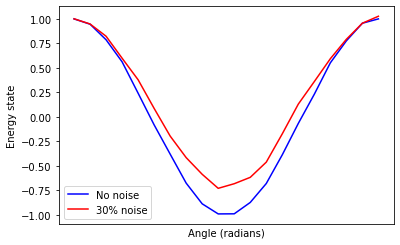

In [7]:
c = ClassicalOptimizer()
n = c.define_noise_model(0.3, 1, ["rx", "h"])
c.run_vqe(angle_range=np.linspace(0, 2 * np.pi, 20), noise_model=n)
c.create_graph()


On a 2-qubit gate such as the CNOT gate in our circuit, 30% noise has a more pronounced affect.


Ground state: -0.9889999999999999
Angle (theta) for ground state:  3.306939635357677
Ground state: -0.5189999999999999
Angle (theta) for ground state:  3.306939635357677


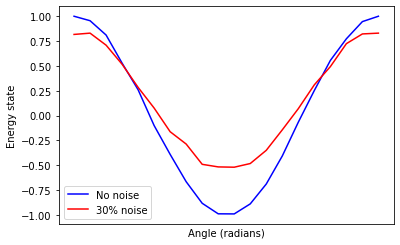

In [8]:
c = ClassicalOptimizer()
n = c.define_noise_model(0.3, 2, ["cx"])
c.run_vqe(angle_range=np.linspace(0, 2 * np.pi, 20), noise_model=n)
c.create_graph()


In addition to seeing an even more elevated global miminum, we are also starting to see the upper bound decrease also from 1 to around 0.8. Along with that, we can observe that the 30% noise graph contains more pronounced and sharper edges which is a peculiar effect of noise on our VQE circuit. Later we will see that one of our classical optimizers will not be able to overcome this amount of noise. 

#### The effect of non-smooth surface on classical optimizers 

Another subtle characteristic of the effect of noise on VQE is the increase of sharper edges on the red line as opposed to the blue. These sharper edge can make our classical optimizers run through additional intervals as it tries to overcome it since the path to the global minimum has become less predictable. Though the smoothness of the curve lends to more efficient optimization, optimizers such as `imfil` are apparently good for non-smooth surfaces.

From the exercise below, we are using the `imfil` optimizer with a noise model for 30% noise on the CNOT gate, we can see that aside from the obvious issues from the flattening of the curve, the sharp edges seem not to bother the optimization too much compared to the circuit with no noise.

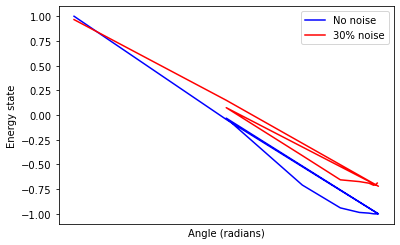

In [9]:
c = ClassicalOptimizer()
n = c.define_noise_model(0.3, 1, ["rx", "h"])
c.run_optimizer(angle_range=np.linspace(0, 2 * np.pi, 20), noise_model=n, optimizer="imfil")
c.create_graph()


Compared to `imfil`, `pybobyqa` did not fare so well. In fact, running the optimizer a number of times gave vastly different results. Sometimes a coherent line was present and other times it was just a compact scribble of lines. In all of these cases one consistent fact was that on average the "no noise" optimizer took about 42 intervals to come to the ground state, while the "30% noise model" never actually completes its proceed. It will eat up the budget of any amount.   

/Users/pchung/Desktop/qosf_mentorship_2020/venv/lib/python3.7/site-packages/pybobyqa/solver.py:795: RuntimeWarning: x0 below lower bound, adjusting
  warnings.warn("x0 below lower bound, adjusting", RuntimeWarning)


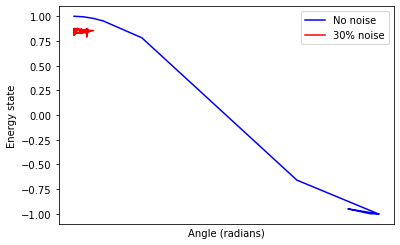

In [10]:
c = ClassicalOptimizer()
n = c.define_noise_model(0.3, 2, ["cx"])
c.run_optimizer(angle_range=np.linspace(0, 2 * np.pi, 20), noise_model=n, optimizer="pybobyqa")
c.create_graph()


I believe we're just scratching the surface here on the efficiency of classical optimizers as well as possible ways to mitigate the effects of noise on quantum circuits. Given more time I would like to dive deeper into the method that `infil` uses to traverse these non-smooth lines as well as the different methods of classical optimizations useful for this type of quantum computation. 

## Where do we go from here?

Through the process of research VQE, I jot down a number of questions that I would love to explore further:

* How do we correct errors from noise in VQE? are there algorithms and circuit design for this?
* What would this circuit look like if we had 3 qubits? n qubits?
* The art of figuring out a good ansatz? What are the parameters for "goodness" of an ansatz?
* Explore more classical optimizers that would be useful for VQE and VQE-like problems. Perhaps even try to implement a simple one?
* From diving into classical optimizers I became more interested in the idea of quantum optimization algorithms such as  QAOA (Quantum Appromixation )

## Bibliography 

For conceptual overview of VQE, I found the following incredibly informative:
- https://www.mustythoughts.com/variational-quantum-eigensolver-explained
- https://github.com/DavitKhach/quantum-algorithms-tutorials/blob/master/variational_quantum_eigensolver.ipynb
- https://github.com/alexander-soare/framework-agnostic-vqe-tutorial
- https://joshuagoings.com/blog/
- https://qiskit.org/textbook/ch-applications/vqe-molecules.html

I also thoroughly enjoyed the paper on Classical Optimizers on NISQ Quantum devices. As a bonus, it was very readable.
[Classical Optimizers for Noisy Intermediate-Scale Quantum Devices](https://arxiv.org/pdf/2004.03004.pdf)

